# Exercise 3 - part A: eQTL analysis | **Association test**
### Chosen datasets: ```Blood stem cell (GSE18067)```, ```Erythroid (GSE18067)```
### Chosen phenotype: `Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death]`

#### Written by: Shani Soustiel, id 316315720 and Shir Tova Segev, id 207353822

### Importing the necessary libraries


In [2]:
import time

import pandas as pd
import numpy as np
from scipy.stats import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed

CELL_TYPE = "Erythroid"  # Erythroid, Stem

### Load data

In [2]:
with open(f"./data/preprocessed_{CELL_TYPE}.pkl", "rb") as f:
    cell_mat = pickle.load(f)   # gene expression
    cell_snps = pickle.load(f)  # snps
    pd_meta = pickle.load(f)    # gene metadata

### Chromosome lengths

In [3]:
chrom_size = [197195432, 181748087, 159599783, 155630120, 152537259,
              149517037, 152524553, 131738871, 124076172, 129993255,
              121843856, 121257530, 120284312, 125194864, 103494974,
              98319150, 95272651, 90772031, 61342430, 166650296]

chrom_start = np.cumsum([0] + chrom_size[:-1])
chrom_end = np.cumsum(chrom_size)

### Convert to coordinate
Function `find_loc` to convert gene and snp names to coordinates on the genome

In [4]:
def find_loc(stem_mat, pd_meta, stem_snps):
    # gene to coordinate
    genes_loc = []
    for gene in stem_mat.index:
        if gene not in pd_meta.index:
            continue
        loc = chrom_start[int(pd_meta.loc[gene]["chrom"])-1] + pd_meta.loc[gene]["start"]
        genes_loc.append(loc)

    # snp to coordinate
    snps_loc = []
    for snp in stem_snps.index:
        loc = chrom_start[int(stem_snps.loc[snp]["Chr_Build37"])-1] + stem_snps.loc[snp]["Build37_position"]
        snps_loc.append(loc)

    return np.array(genes_loc), np.array(snps_loc)

genes_loc, snps_loc = find_loc(cell_mat, pd_meta, cell_snps)

### Association test - implementing _linear regression_

In [ ]:
X = cell_snps[cell_snps.columns[2:]].map(lambda x: 1 if x == "B" else 0 if x == "D" else None).values
Y = cell_mat.values

# Function to compute p-values for a given index
def compute_p_values(i, Y, X):
    p_values_row = np.zeros(len(X))
    for j in range(len(X)):
        p_values_row[j] = stats.linregress(Y[i], X[j])[3]  # 3rd value is the p-value
    if i % 10 == 0:
        print(f"{i} / {len(Y)} done")
    return p_values_row

# Initialize p-values array
p_values = np.zeros((len(Y), len(X)))

# Measure time
tm = time.time()

# Parallel processing
p_values = Parallel(n_jobs=-1)(delayed(compute_p_values)(i, Y, X) for i in range(len(Y)))

# Convert list of arrays to a single array
p_values = np.array(p_values)

# Print time taken
print(f"Completed in {time.time() - tm} seconds")

### Sort data

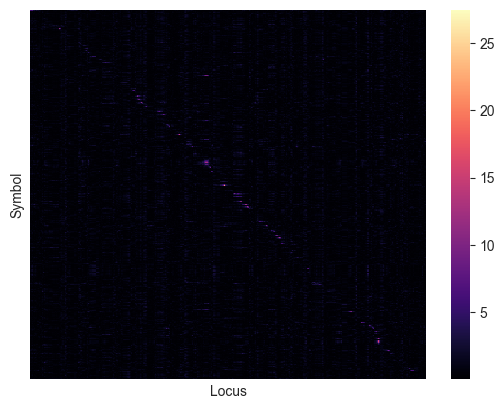

In [5]:
# convert p_values to DataFrame with cell_mat.index as index and cell_snps.index as columns
data_res = pd.DataFrame(p_values, index=cell_mat.index, columns=cell_snps.index)

# sort data_res by snps_loc and genes_loc
data_res = data_res[data_res.columns[np.argsort(snps_loc)]]
data_res = data_res.iloc[np.argsort(genes_loc)]
    
# sort genes_loc and snps_loc
genes_loc = np.sort(genes_loc)
snps_loc = np.sort(snps_loc)

sns.heatmap(-np.log10(data_res), xticklabels=False, yticklabels=False, cmap='magma')
plt.show()

### Save data

In [ ]:
with open(f"./data/association_{CELL_TYPE}.pkl", "wb") as f:
    pickle.dump(data_res, f)
    pickle.dump(genes_loc, f)
    pickle.dump(snps_loc, f)